In [1]:
from pfp_stat import *

import numpy as np
import pandas as pd 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib

import datetime as dat

from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF
import fpdf

from pfp_products import *

import os.path
from scipy.optimize import minimize

In [2]:
def mirr(wghts):
    a1 = (payoffs*wghts).sum(axis = 2)    
    a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
    a2[1:,:] = a1
    a3 = np.array([np.irr(x) for x in np.transpose(a2)]) 
    return a3

def func(wghts):
    a3 = mirr(wghts)
    return -(a3.mean())/(a3.std())

In [3]:
print('Okay, lets see what we have here.')

prodcat_filename = 'inputs/prod_cat open.xlsx'
prodcat_sheetname = 'prod cat'

xls = pd.read_excel(prodcat_filename, prodcat_sheetname, 
                         decimal = '.', usecols = 'b:z', 
                         index_col = 0, header = 1)

print('I`m using `' + prodcat_sheetname + '` sheet of `' + prodcat_filename + '` file as product catalog.')

products = xls.transpose()
all_BAs = []
prod_list = []
max_term = 0

for prod, row in products.iterrows():
    
    check = check_stat(row.BAs)
    
    if check:        
        all_BAs.extend(row.BAs.split(', '))
        all_BAs = list(set(all_BAs))
        
        if row.term > max_term: max_term = row.term

        Note1 = Structure(prod, row.BAs, row.notional_curr, row.term, 
                  row.coupon_value, row.coupon_always, row.coupon_check_months, row.coupon_memory, 
                  row.coupon_lower_barrier, row.coupon_upper_barrier,
                  row.autocall_flag, row.autocall_check_months, row.autocall_barrier, row.autocall_barrier_increase_rate,
                  row.redemption_amount, row.redemption_put_strike, row.redemption_guarantee_rule,
                  row.redemption_upside_participation, row.redemption_downside_participation, row.issuer)
        Note1.stats_ok = True
        
        prod_list.append(Note1)
    else: 
        print ('We dont have enough statistics for ' + row.name + ' underlyings. We do not calculate it now.')

print('...')
print('All products from `prod cat.xls` except mentioned above are successfully loaded.')

Okay, lets see what we have here.
I`m using `prod cat` sheet of `inputs/prod_cat open.xlsx` file as product catalog.
...
All products from `prod cat.xls` except mentioned above are successfully loaded.


In [4]:
n_scenarios = 50000
simulation_years = max_term   

returns = ba_scenarios(all_BAs, 
                       simulation_years,  
                       n_scenarios, 
                       print_statistics = True,
                       points_in_year = 12)
print('Scenarios ready!')

Returns: 
rog sw equity     0.034
open pif          0.121
solecmvt index    0.025
gmkn rx equity    0.079
yndx rx equity    0.121
moex rx equity    0.082
mtss rx equity    0.092
alrs rx equity    0.087
Name: r, dtype: float64
 
Sigmas: 
rog sw equity     0.156097
open pif          0.143242
solecmvt index    0.096891
gmkn rx equity    0.191840
yndx rx equity    0.323618
moex rx equity    0.213164
mtss rx equity    0.249655
alrs rx equity    0.278227
dtype: float32
 
Correlations: 

                rog sw equity  open pif  solecmvt index  gmkn rx equity  \
rog sw equity        1.000000  0.094408        0.011685       -0.124118   
open pif             0.094408  1.000000        0.074107        0.406332   
solecmvt index       0.011685  0.074107        1.000000        0.291811   
gmkn rx equity      -0.124118  0.406332        0.291811        1.000000   
yndx rx equity      -0.005998  0.620546        0.099164        0.013790   
moex rx equity       0.031895  0.670502        0.302035        0

In [5]:
flag = 1
for prod in prod_list:
    
    print('Calculating ' + prod.name)
    
    a1 = prod.payoff(all_BAs, returns, to_pdf = False)
    # a1 - массив размера self.time_steps x n_scenarios
    
    a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
    a2[1:,:] = a1
    a3 = np.array([np.irr(x) for x in np.transpose(a2)])
    
    x = a3.std()
    y = a3.mean()
    z = a3.min()
    
    print('    mean return (annualized IRR):    %4.3f' %y)
    print('    min return (annualized IRR):    %4.3f' %z)

    if flag == 1:
        flag = 0
        payoffs = a1
        irrs = a3
        points1 = [x, y]
        points2 = [z, y]
        
        names = [prod.name]
    else:
        payoffs = np.dstack([payoffs, a1])
        irrs = np.c_[irrs, a3]
        points1 = np.c_[points1, [x, y]]
        points2 = np.c_[points2, [z, y]]
        names.append(prod.name)
print('Done!')

Calculating GMKN AM
    mean return (annualized IRR):    0.036
    min return (annualized IRR):    0.000
Calculating Rosche AM
    mean return (annualized IRR):    0.024
    min return (annualized IRR):    0.000
Calculating Basket coupon
    mean return (annualized IRR):    0.045
    min return (annualized IRR):    0.000
Calculating Open PIF
    mean return (annualized IRR):    0.121
    min return (annualized IRR):    -0.208
Calculating Solars
    mean return (annualized IRR):    0.028
    min return (annualized IRR):    0.000
Done!


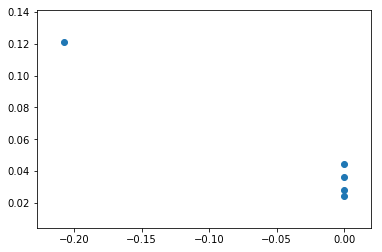

In [6]:
# посмотрим продукты на плоскости риск-доходность:

plt.scatter(points2[0,:], points2[1,:])
plt.show()

In [7]:
%%time
# задаем ограничения на веса:
cons = ({'type': 'eq', 'fun' : lambda x: x.sum()-1},
        {'type': 'ineq','fun' : lambda x: 1 - x.max()},
        {'type': 'ineq','fun' : lambda x: x.min()})

# начальные значения весов (всех продуктов поровну)
x0 = np.ones(payoffs.shape[-1])/payoffs.shape[-1]
res = minimize(func, x0, method='SLSQP', options={'disp': True}, constraints=cons)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.6599556536445523
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9
CPU times: user 5min 9s, sys: 15 s, total: 5min 24s
Wall time: 5min 11s


In [8]:
print('weights: %4.2f' % res.x)

print '\n'.join(['%i: %s' % (n, l[n]) for n in xrange(len(l))])


#print(res.x)

SyntaxError: invalid syntax (<ipython-input-8-1ee7a324e483>, line 3)

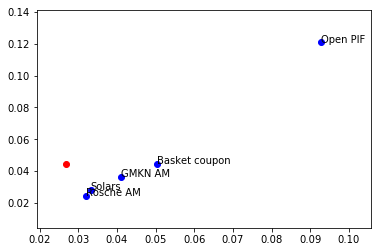

In [9]:
plt.scatter(points1[0,:], points1[1,:], c='blue')
plt.scatter(mirr(res.x).std(), mirr(res.x).mean(), c='red')

for i, txt in enumerate(names):
    plt.annotate(txt, (points1[0,i], points1[1,i]))
plt.show()

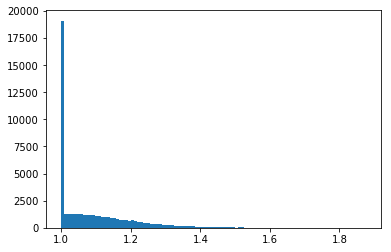

In [10]:
plt.hist(payoffs[:,:,-1].sum(axis = 0), bins = 100)
plt.show()

In [12]:
%%time
a = mirr([0,0,0,0,1])

CPU times: user 4.66 s, sys: 40.2 ms, total: 4.7 s
Wall time: 4.65 s


In [35]:
solars_payoffs = payoffs[-1,:,-1]

In [38]:
solars_payoffs.mean()

1.0900633543485638

In [39]:
solars_returns = returns[-1,:,3]

In [42]:
solars_returns.mean()

1.320389514528483

In [29]:
solars_returns = returns[-1,:,3]

In [30]:
solars_returns.mean()

1.320389514528483

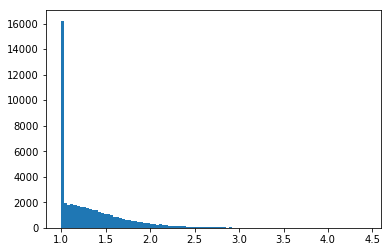

In [43]:
plt.hist(solars_returns, bins = 100)
plt.show()

In [26]:
solars_returns.mean()

1.179751764066069

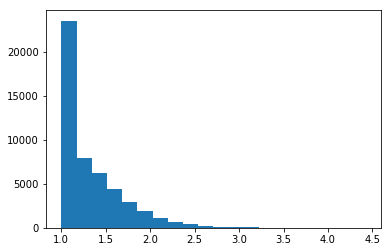

In [21]:
solars_returns[solars_returns < 1 ] = 1
plt.hist(solars_returns, bins = 20)
plt.show()

In [22]:
solars_returns.mean()

1.320389514528483

In [23]:
solars_returns = returns[-1,3,:]

In [24]:
solars_positive = solars_returns[solars_returns>1]

In [25]:
solars_positive

array([1.28151557, 1.33237015, 1.28818673, 1.77715571, 1.42426285])

In [44]:
returns.shape

(36, 50000, 8)

In [46]:
solar_returns = returns[-1,:,2]

In [49]:
solar_returns.mean()

1.0784950767995742

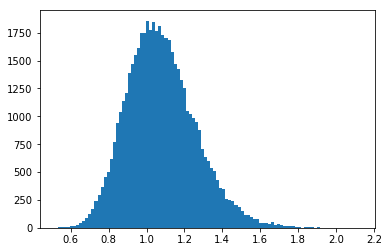

In [52]:
#solars_returns[solars_returns < 1 ] = 1
plt.hist(solar_returns, bins = 100)
plt.show()

In [57]:
solar_returns[solar_returns>1].mean()

1.179445247425505

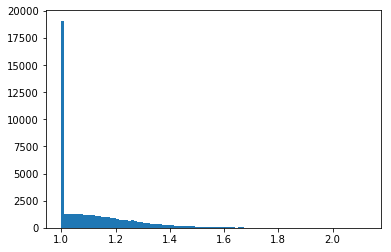

In [54]:
solar_returns_positive = solar_returns
solar_returns_positive[solar_returns_positive < 1 ] = 1
plt.hist(solar_returns_positive, bins = 100)
plt.show()

In [55]:
solar_returns_positive.mean()

1.1154658389084156

In [56]:
solar_returns_positive.mean()**(1/3)

1.0370955199324143